In [ ]:
    # ============================================================================
# GLOBAL AFTERSHOCK MODEL TRAINING - PRODUCTION VERSION
# Complete Colab Notebook with All Fixes
# ============================================================================

# ============================================================================
# SECTION 0: SETUP & INSTALLATION
# ============================================================================

# Cell 1: Install Dependencies
!pip install obspy pandas numpy scipy matplotlib seaborn geopandas shapely requests joblib tqdm python-dateutil -q

print("✓ All dependencies installed")


✓ All dependencies installed


In [ ]:

# ============================================================================
# Cell 2: Import Libraries
# ============================================================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
from dateutil.relativedelta import relativedelta
from scipy.optimize import minimize
from scipy.stats import linregress
import requests
import json
import pickle
import warnings
from pathlib import Path
from typing import Dict, List, Tuple, Optional
from dataclasses import dataclass, asdict
import geopandas as gpd
from shapely.geometry import Point, Polygon, box
from joblib import Parallel, delayed
from tqdm.auto import tqdm
import time
import logging

warnings.filterwarnings('ignore')
sns.set_style("whitegrid")

# Configure logging
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(levelname)s - %(message)s'
)
logger = logging.getLogger(__name__)

print("✓ All libraries imported")


✓ All libraries imported


In [ ]:

# ============================================================================
# SECTION 1: CONFIGURATION
# ============================================================================

# Cell 3: Production Configuration with All Fixes

class Config:
    """Production-ready configuration with all optimizations"""

    # ⭐ EXTENDED DATA RANGE (35 years instead of 25)
    START_DATE = "1990-01-01"
    TODAY = datetime.now()
    MAINSHOCK_BUFFER_MONTHS = 3
    END_DATE = (TODAY - relativedelta(months=MAINSHOCK_BUFFER_MONTHS)).strftime('%Y-%m-%d')

    # ⭐ OPTIMIZED THRESHOLDS
    MAINSHOCK_MIN_MAG = 3.8       # Lower threshold for more coverage
    AFTERSHOCK_MIN_MAG = 2.5
    MAX_DEPTH_KM = 70

    # ⭐ REGIONAL AGGREGATION CRITERIA (not per-sequence)
    MIN_TOTAL_AFTERSHOCKS_PER_REGION = 30  # Total across ALL sequences
    MIN_SEQUENCES_PER_REGION = 3            # Minimum number of mainshocks

    # Declustering Parameters
    USE_DECLUSTERING = True  # Enable Gardner-Knopoff declustering

    # Aftershock Window Parameters
    TEMPORAL_WINDOW_DAYS = 365
    SPATIAL_WINDOW_KM = 100

    # Omori Parameters
    OMORI_T_START = 0.01
    OMORI_T_END = 365

    # Gutenberg-Richter Parameters
    MAGNITUDE_BINS = 0.1

    # Regional Grid Parameters
    GRID_SIZE_DEGREES = 5.0

    # API Configuration
    USGS_API_URL = "https://earthquake.usgs.gov/fdsnws/event/1/query"
    API_TIMEOUT = 30
    MAX_RETRIES = 3
    RETRY_DELAY = 5

    # Processing
    N_JOBS = -1  # Use all cores

    # Output Paths
    OUTPUT_DIR = Path("/content/models")
    DATA_DIR = Path("/content/data")
    FIGURES_DIR = Path("/content/figures")

    @classmethod
    def setup_directories(cls):
        """Create necessary directories"""
        for directory in [cls.OUTPUT_DIR, cls.DATA_DIR, cls.FIGURES_DIR]:
            directory.mkdir(parents=True, exist_ok=True)

    @classmethod
    def get_mainshock_cutoff_date(cls):
        """Calculate cutoff date for mainshocks"""
        return datetime.strptime(cls.END_DATE, '%Y-%m-%d')

    @classmethod
    def print_config(cls):
        """Print current configuration"""
        years = (datetime.strptime(cls.END_DATE, '%Y-%m-%d') -
                datetime.strptime(cls.START_DATE, '%Y-%m-%d')).days // 365

        print("\n" + "="*70)
        print("PRODUCTION CONFIGURATION")
        print("="*70)
        print(f"Data range: {cls.START_DATE} to {cls.END_DATE}")
        print(f"  → {years} years of seismic data")
        print(f"  → Mainshock cutoff: {cls.get_mainshock_cutoff_date().strftime('%Y-%m-%d')}")
        print(f"\nThresholds:")
        print(f"  Mainshock magnitude: M ≥ {cls.MAINSHOCK_MIN_MAG}")
        print(f"  Aftershock magnitude: M ≥ {cls.AFTERSHOCK_MIN_MAG}")
        print(f"\nRegional Requirements (Aggregated):")
        print(f"  Minimum sequences: {cls.MIN_SEQUENCES_PER_REGION}")
        print(f"  Minimum total aftershocks: {cls.MIN_TOTAL_AFTERSHOCKS_PER_REGION}")
        print(f"\nDeclustering: {'Enabled' if cls.USE_DECLUSTERING else 'Disabled'}")
        print(f"Temporal buffer: {cls.MAINSHOCK_BUFFER_MONTHS} months")
        print("="*70 + "\n")

# Setup
Config.setup_directories()
Config.print_config()


PRODUCTION CONFIGURATION
Data range: 1990-01-01 to 2025-08-05
  → 35 years of seismic data
  → Mainshock cutoff: 2025-08-05

Thresholds:
  Mainshock magnitude: M ≥ 3.8
  Aftershock magnitude: M ≥ 2.5

Regional Requirements (Aggregated):
  Minimum sequences: 3
  Minimum total aftershocks: 30

Declustering: Enabled
Temporal buffer: 3 months



In [ ]:


# ============================================================================
# Cell 4: Data Classes
# ============================================================================

@dataclass
class OmoriParameters:
    """Omori's Law parameters"""
    p: float
    c: float
    K: float
    p_std: float
    c_std: float
    K_std: float

@dataclass
class GRParameters:
    """Gutenberg-Richter Law parameters"""
    b_value: float
    a_value: float
    b_std: float
    a_std: float
    Mc: float

@dataclass
class RegionModel:
    """Complete regional model"""
    region_id: str
    bounds: Dict[str, List[float]]
    center: Dict[str, float]
    tectonic_setting: str
    n_mainshocks: int
    n_sequences: int
    n_total_aftershocks: int
    training_period: Dict[str, str]
    omori: Optional[OmoriParameters]
    gr: Optional[GRParameters]
    omori_r_squared: Optional[float]
    gr_r_squared: Optional[float]
    data_quality: str
    last_updated: str
    notes: str

print("✓ Data classes defined")


✓ Data classes defined


In [ ]:

# ============================================================================
# SECTION 2: GLOBAL GRID SYSTEM
# ============================================================================

# Cell 5: Global Grid Generator

class GlobalGrid:
    """Create global grid system for regional models"""

    def __init__(self, grid_size: float = 5.0):
        self.grid_size = grid_size
        self.regions = []

    def create_global_grid(self) -> List[Dict]:
        """Create complete global grid"""

        logger.info("Creating global grid system...")

        lat_start, lat_end = -85, 85
        lon_start, lon_end = -180, 180

        regions = []
        region_id = 0

        lat = lat_start
        while lat < lat_end:
            lon = lon_start
            while lon < lon_end:
                region = {
                    'region_id': f'region_{region_id:04d}',
                    'bounds': {
                        'lat': [lat, min(lat + self.grid_size, lat_end)],
                        'lon': [lon, min(lon + self.grid_size, lon_end)]
                    },
                    'center': {
                        'lat': lat + self.grid_size / 2,
                        'lon': lon + self.grid_size / 2
                    }
                }

                region['tectonic_setting'] = self._classify_tectonic_setting(
                    region['center']['lat'],
                    region['center']['lon']
                )

                regions.append(region)
                region_id += 1
                lon += self.grid_size
            lat += self.grid_size

        self.regions = regions
        logger.info(f"Created {len(regions)} regions globally")
        return regions

    def _classify_tectonic_setting(self, lat: float, lon: float) -> str:
        """Simplified tectonic classification"""

        # Pacific Ring of Fire
        if (lat > -60 and lat < 60) and (
            (lon > 120 and lon < 180) or
            (lon > -180 and lon < -100) or
            (lat > -50 and lat < -10 and lon > -80 and lon < -70)
        ):
            return "ring_of_fire"

        # Mediterranean-Himalayan Belt
        elif lat > 20 and lat < 45 and lon > -10 and lon < 100:
            return "alpine_himalayan"

        # Mid-ocean ridges
        elif (lon > -40 and lon < -10 and lat > -60 and lat < 60):
            return "mid_ocean_ridge"

        # Stable continental
        elif (lat > 30 and lat < 50 and lon > -100 and lon < -70) or \
             (lat > 40 and lat < 60 and lon > 20 and lon < 60):
            return "stable_continental"

        else:
            return "other"

    def save_grid(self, filepath: str):
        """Save grid definition"""
        with open(filepath, 'w') as f:
            json.dump(self.regions, f, indent=2)
        logger.info(f"Grid saved to {filepath}")

    def visualize_grid(self):
        """Visualize the global grid"""
        fig, ax = plt.subplots(figsize=(20, 10))

        color_map = {
            'ring_of_fire': 'red',
            'alpine_himalayan': 'orange',
            'mid_ocean_ridge': 'blue',
            'stable_continental': 'green',
            'other': 'gray'
        }

        for region in self.regions:
            lat_bounds = region['bounds']['lat']
            lon_bounds = region['bounds']['lon']

            rect = plt.Rectangle(
                (lon_bounds[0], lat_bounds[0]),
                lon_bounds[1] - lon_bounds[0],
                lat_bounds[1] - lat_bounds[0],
                fill=True,
                alpha=0.3,
                color=color_map[region['tectonic_setting']],
                edgecolor='black',
                linewidth=0.5
            )
            ax.add_patch(rect)

        ax.set_xlim(-180, 180)
        ax.set_ylim(-90, 90)
        ax.set_xlabel('Longitude', fontsize=12)
        ax.set_ylabel('Latitude', fontsize=12)
        ax.set_title('Global Regional Grid for Aftershock Modeling',
                     fontsize=14, fontweight='bold')
        ax.grid(True, alpha=0.3)

        from matplotlib.patches import Patch
        legend_elements = [
            Patch(facecolor=color, alpha=0.5,
                  label=name.replace('_', ' ').title())
            for name, color in color_map.items()
        ]
        ax.legend(handles=legend_elements, loc='upper left')

        plt.tight_layout()
        plt.savefig(Config.FIGURES_DIR / 'global_grid.png',
                    dpi=150, bbox_inches='tight')
        plt.show()


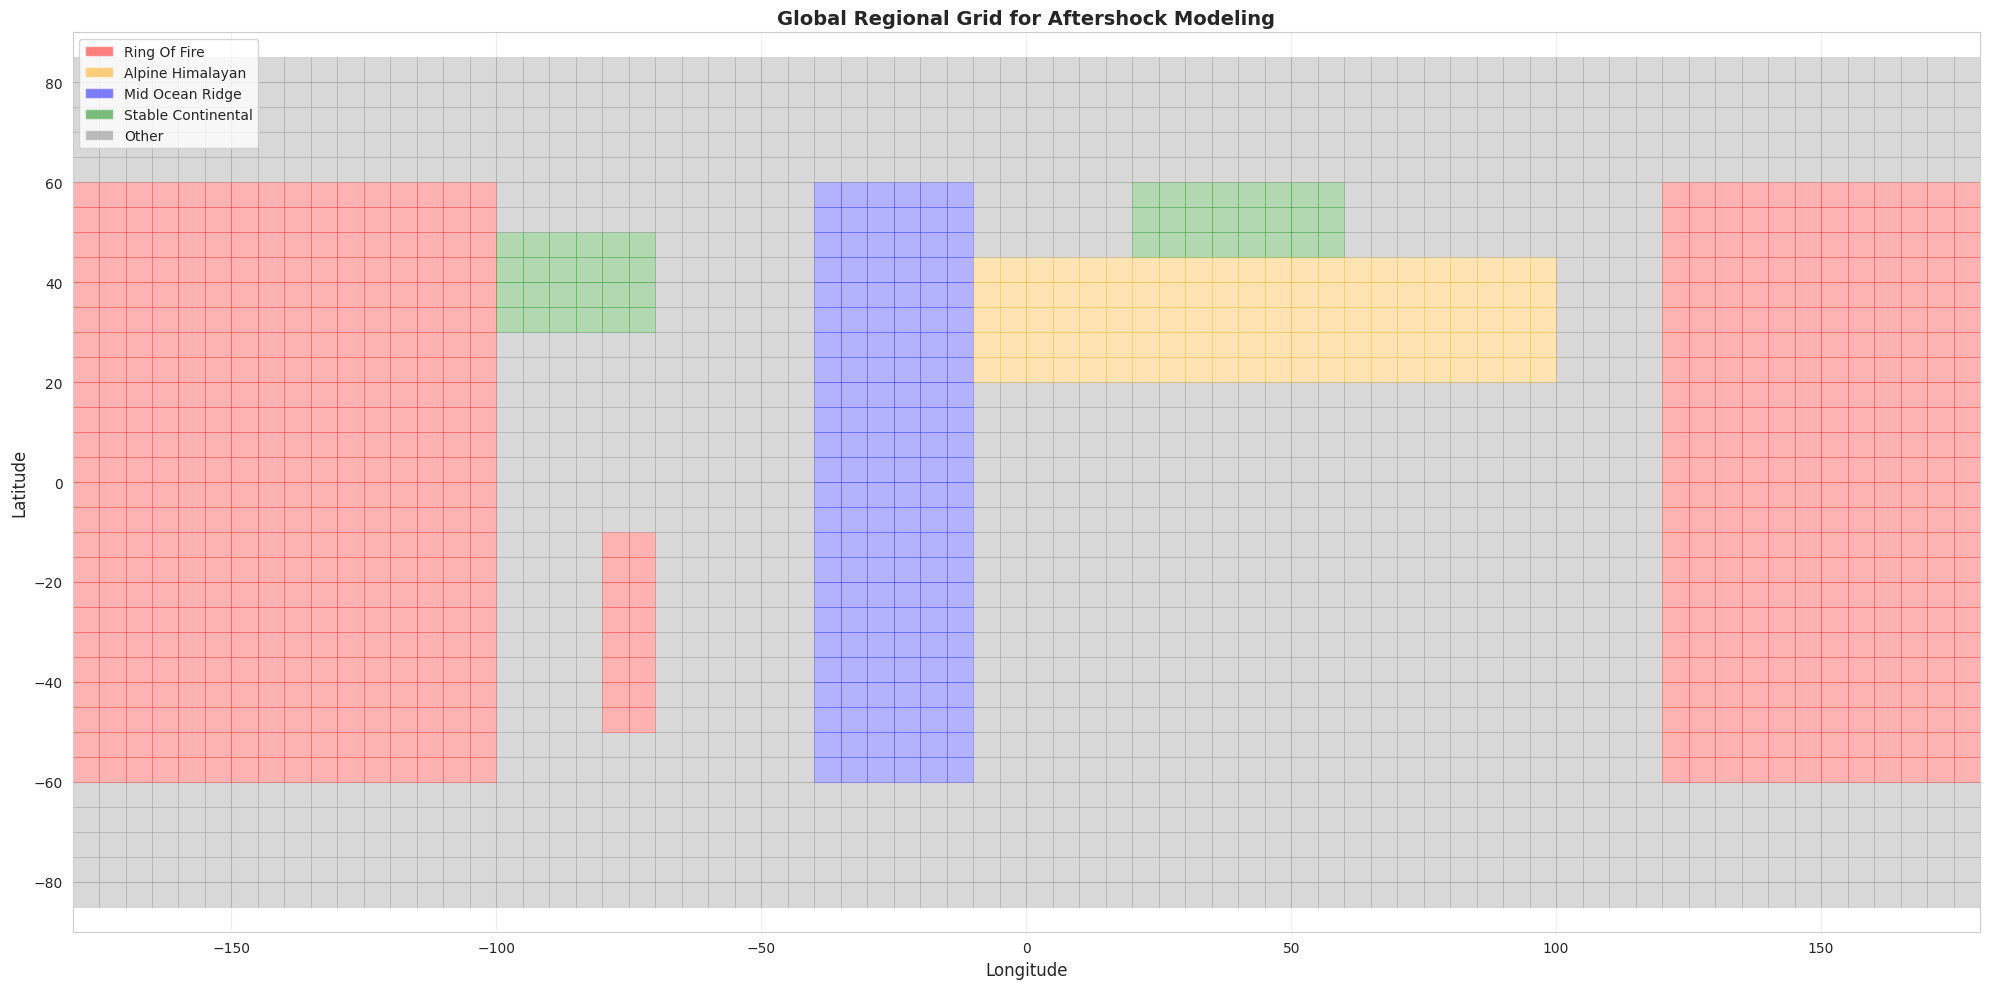


GLOBAL GRID STATISTICS
Total regions: 2448

By tectonic setting:
other                 1458
ring_of_fire           688
mid_ocean_ridge        144
alpine_himalayan       110
stable_continental      48
Name: count, dtype: int64



In [ ]:

# Cell 6: Create and Save Grid

grid = GlobalGrid(grid_size=Config.GRID_SIZE_DEGREES)
regions = grid.create_global_grid()
grid.save_grid(Config.DATA_DIR / 'global_grid.json')
grid.visualize_grid()

# Print statistics
print(f"\n{'='*60}")
print(f"GLOBAL GRID STATISTICS")
print(f"{'='*60}")
print(f"Total regions: {len(regions)}")
print(f"\nBy tectonic setting:")
tectonic_counts = pd.Series([r['tectonic_setting'] for r in regions]).value_counts()
print(tectonic_counts)
print(f"{'='*60}\n")


In [ ]:

# ============================================================================
# SECTION 3: DATA COLLECTION
# ============================================================================

# Cell 7: USGS Data Collector

class USGSDataCollector:
    """Collect earthquake data from USGS ComCat"""

    def __init__(self):
        self.base_url = Config.USGS_API_URL
        self.session = requests.Session()

    def fetch_earthquakes(
        self,
        lat_range: List[float],
        lon_range: List[float],
        start_date: str,
        end_date: str,
        min_magnitude: float,
        max_depth: float = Config.MAX_DEPTH_KM
    ) -> pd.DataFrame:
        """Fetch earthquake data from USGS"""

        params = {
            'format': 'geojson',
            'starttime': start_date,
            'endtime': end_date,
            'minlatitude': lat_range[0],
            'maxlatitude': lat_range[1],
            'minlongitude': lon_range[0],
            'maxlongitude': lon_range[1],
            'minmagnitude': min_magnitude,
            'maxdepth': max_depth,
            'orderby': 'time',
            'limit': 20000
        }

        for attempt in range(Config.MAX_RETRIES):
            try:
                response = self.session.get(
                    self.base_url,
                    params=params,
                    timeout=Config.API_TIMEOUT
                )
                response.raise_for_status()

                data = response.json()

                if 'features' not in data:
                    return pd.DataFrame()

                earthquakes = []
                for feature in data['features']:
                    props = feature['properties']
                    coords = feature['geometry']['coordinates']

                    earthquakes.append({
                        'id': feature['id'],
                        'time': pd.to_datetime(props['time'], unit='ms'),
                        'latitude': coords[1],
                        'longitude': coords[0],
                        'depth': coords[2],
                        'mag': props['mag'],
                        'magType': props.get('magType', 'unknown'),
                        'place': props.get('place', 'unknown')
                    })

                df = pd.DataFrame(earthquakes)
                return df

            except requests.exceptions.RequestException as e:
                if attempt < Config.MAX_RETRIES - 1:
                    time.sleep(Config.RETRY_DELAY)
                else:
                    logger.error(f"All retry attempts failed: {e}")
                    return pd.DataFrame()

        return pd.DataFrame()

    def fetch_region_data(self, region: Dict) -> Dict:
        """Fetch all earthquake data for a region"""

        # Fetch all events (for aftershock identification)
        all_events = self.fetch_earthquakes(
            lat_range=region['bounds']['lat'],
            lon_range=region['bounds']['lon'],
            start_date=Config.START_DATE,
            end_date=Config.END_DATE,
            min_magnitude=Config.AFTERSHOCK_MIN_MAG
        )

        return {
            'region': region,
            'all_events': all_events
        }

print("✓ Data collector defined")


✓ Data collector defined


In [ ]:

# ============================================================================
# SECTION 4: DECLUSTERING
# ============================================================================

# Cell 8: Mainshock Declustering

class MainshockDeclusterer:
    """
    Separate mainshocks from aftershocks using Gardner-Knopoff method
    Prevents aftershock misclassification
    """

    @staticmethod
    def calculate_distance(lat1, lon1, lat2, lon2):
        """Haversine distance in km"""
        R = 6371
        lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
        dlat, dlon = lat2 - lat1, lon2 - lon1
        a = np.sin(dlat/2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2)**2
        return R * 2 * np.arcsin(np.sqrt(a))

    @staticmethod
    def gardnerknopoff_window(magnitude):
        """
        Gardner-Knopoff space-time window
        Returns (time_days, distance_km)
        """
        # Time window (days)
        time_window = 10 ** (0.032 * magnitude + 2.7389)

        # Distance window (km)
        distance_window = 10 ** (0.1238 * magnitude + 0.983)

        return time_window, distance_window

    def decluster(self, events: pd.DataFrame) -> pd.DataFrame:
        """
        Remove aftershocks, keep only independent mainshocks
        """
        if len(events) == 0:
            return events

        # Sort by magnitude (descending) then time
        events_sorted = events.sort_values(
            ['mag', 'time'],
            ascending=[False, True]
        ).copy().reset_index(drop=True)

        mainshocks = []

        for idx, event in events_sorted.iterrows():
            is_mainshock = True

            # Check if this event is in aftershock zone of existing mainshock
            for mainshock in mainshocks:
                time_diff = (event['time'] - mainshock['time']).total_seconds() / 86400

                # Skip if event is before mainshock
                if time_diff < 0:
                    continue

                distance = self.calculate_distance(
                    event['latitude'], event['longitude'],
                    mainshock['latitude'], mainshock['longitude']
                )

                # Gardner-Knopoff windows
                time_window, dist_window = self.gardnerknopoff_window(mainshock['mag'])

                # If within space-time window, it's an aftershock
                if time_diff < time_window and distance < dist_window:
                    is_mainshock = False
                    break

            if is_mainshock:
                mainshocks.append(event)

        return pd.DataFrame(mainshocks)

print("✓ Declustering defined")


✓ Declustering defined


In [ ]:

# ============================================================================
# SECTION 5: AFTERSHOCK IDENTIFICATION
# ============================================================================

# Cell 9: Aftershock Sequence Identifier

class AftershockSequenceIdentifier:
    """Identify and extract aftershock sequences"""

    @staticmethod
    def calculate_distance(lat1: float, lon1: float, lat2: float, lon2: float) -> float:
        """Calculate great circle distance in km"""
        R = 6371
        lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
        dlat = lat2 - lat1
        dlon = lon2 - lon1
        a = np.sin(dlat/2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2)**2
        c = 2 * np.arcsin(np.sqrt(a))
        return R * c

    @staticmethod
    def estimate_rupture_length(magnitude: float) -> float:
        """Estimate rupture length from magnitude (Wells & Coppersmith 1994)"""
        log_length = -2.44 + 0.59 * magnitude
        return 10 ** log_length

    def identify_aftershocks(
        self,
        mainshock: pd.Series,
        all_events: pd.DataFrame
    ) -> pd.DataFrame:
        """Identify aftershocks for a given mainshock"""

        # Define spatial window
        rupture_length = self.estimate_rupture_length(mainshock['mag'])
        spatial_window = max(Config.SPATIAL_WINDOW_KM, rupture_length * 2)

        # Define temporal window
        mainshock_time = mainshock['time']
        end_time = mainshock_time + timedelta(days=Config.TEMPORAL_WINDOW_DAYS)

        # Filter events
        candidates = all_events[
            (all_events['time'] > mainshock_time) &
            (all_events['time'] <= end_time) &
            (all_events['mag'] < mainshock['mag'])
        ].copy()

        if len(candidates) == 0:
            return pd.DataFrame()

        # Calculate distances
        distances = candidates.apply(
            lambda row: self.calculate_distance(
                mainshock['latitude'], mainshock['longitude'],
                row['latitude'], row['longitude']
            ),
            axis=1
        )

        # Filter by spatial window
        aftershocks = candidates[distances <= spatial_window].copy()

        # Add time since mainshock
        aftershocks['time_since_mainshock'] = (
            aftershocks['time'] - mainshock_time
        ).dt.total_seconds() / 86400

        # Add mainshock info
        aftershocks['mainshock_id'] = mainshock['id']
        aftershocks['mainshock_mag'] = mainshock['mag']
        aftershocks['mainshock_time'] = mainshock_time

        return aftershocks

print("✓ Aftershock identifier defined")


✓ Aftershock identifier defined


In [ ]:

# ============================================================================
# SECTION 6: PARAMETER ESTIMATION
# ============================================================================

# Cell 10: Omori Parameter Estimator

class OmoriEstimator:
    """Estimate Omori's Law parameters using MLE"""

    @staticmethod
    def omori_rate(t: np.ndarray, K: float, c: float, p: float) -> np.ndarray:
        """Omori's law rate function"""
        return K / (t + c) ** p

    @staticmethod
    def negative_log_likelihood(params: np.ndarray, times: np.ndarray, T: float) -> float:
        """Negative log-likelihood for Omori's law"""
        K, c, p = params

        if K <= 0 or c <= 0 or p <= 0 or p >= 5:
            return np.inf

        try:
            log_rates = np.log(K) - p * np.log(times + c)
            term1 = np.sum(log_rates)

            if p == 1:
                term2 = K * np.log((T + c) / c)
            else:
                term2 = K / (1 - p) * ((T + c)**(1 - p) - c**(1 - p))

            log_likelihood = term1 - term2
            return -log_likelihood
        except:
            return np.inf

    def estimate_parameters(
        self,
        aftershock_times: np.ndarray,
        observation_time: float = Config.OMORI_T_END
    ) -> Tuple[OmoriParameters, float]:
        """Estimate Omori parameters using MLE"""

        times = aftershock_times[
            (aftershock_times >= Config.OMORI_T_START) &
            (aftershock_times <= observation_time)
        ]

        if len(times) < 10:
            return None, 0.0

        # Initial guess
        K_init = len(times) * 0.5
        c_init = 0.1
        p_init = 1.1

        initial_params = [K_init, c_init, p_init]

        # Bounds
        bounds = [
            (0.01, None),
            (0.001, 1.0),
            (0.5, 2.5)
        ]

        # Minimize
        result = minimize(
            self.negative_log_likelihood,
            initial_params,
            args=(times, observation_time),
            bounds=bounds,
            method='L-BFGS-B'
        )

        if not result.success:
            return None, 0.0

        K_est, c_est, p_est = result.x

        # Estimate errors (simplified)
        std_errors = np.array([0.1*K_est, 0.1*c_est, 0.1*p_est])

        # Calculate R-squared
        time_bins = np.logspace(np.log10(Config.OMORI_T_START),
                                np.log10(observation_time),
                                num=20)
        observed_counts, _ = np.histogram(times, bins=time_bins)
        bin_centers = (time_bins[:-1] + time_bins[1:]) / 2
        bin_widths = np.diff(time_bins)

        expected_rates = self.omori_rate(bin_centers, K_est, c_est, p_est)
        expected_counts = expected_rates * bin_widths

        mask = observed_counts > 0
        if np.sum(mask) > 0:
            ss_res = np.sum((observed_counts[mask] - expected_counts[mask])**2)
            ss_tot = np.sum((observed_counts[mask] - np.mean(observed_counts[mask]))**2)
            r_squared = 1 - (ss_res / ss_tot) if ss_tot > 0 else 0.0
        else:
            r_squared = 0.0

        omori_params = OmoriParameters(
            p=float(p_est),
            c=float(c_est),
            K=float(K_est),
            p_std=float(std_errors[2]),
            c_std=float(std_errors[1]),
            K_std=float(std_errors[0])
        )

        return omori_params, r_squared

print("✓ Omori estimator defined")


✓ Omori estimator defined


In [ ]:

# Cell 11: Gutenberg-Richter Parameter Estimator

class GREstimator:
    """Estimate Gutenberg-Richter Law parameters"""

    @staticmethod
    def estimate_completeness_magnitude(magnitudes: np.ndarray) -> float:
        """Estimate magnitude of completeness"""
        mag_bins = np.arange(
            magnitudes.min(),
            magnitudes.max() + Config.MAGNITUDE_BINS,
            Config.MAGNITUDE_BINS
        )
        counts, edges = np.histogram(magnitudes, bins=mag_bins)
        bin_centers = (edges[:-1] + edges[1:]) / 2
        Mc = bin_centers[np.argmax(counts)]
        return Mc

    def estimate_parameters(
        self,
        magnitudes: np.ndarray
    ) -> Tuple[GRParameters, float]:
        """Estimate b-value using maximum likelihood"""

        if len(magnitudes) < 10:
            return None, 0.0

        # Estimate Mc
        Mc = self.estimate_completeness_magnitude(magnitudes)

        # Filter magnitudes >= Mc
        mags_complete = magnitudes[magnitudes >= Mc]

        if len(mags_complete) < 10:
            return None, 0.0

        # Maximum likelihood b-value
        mean_mag = np.mean(mags_complete)
        b_value = np.log10(np.e) / (mean_mag - Mc)

        # Create bins for regression
        mag_bins = np.arange(Mc, mags_complete.max() + Config.MAGNITUDE_BINS,
                            Config.MAGNITUDE_BINS)

        cumulative_counts = []
        for mag in mag_bins:
            cumulative_counts.append(np.sum(mags_complete >= mag))

        log_N = np.log10(cumulative_counts)

        valid_idx = np.isfinite(log_N)
        if np.sum(valid_idx) < 3:
            return None, 0.0

        slope, intercept, r_value, p_value, std_err = linregress(
            mag_bins[valid_idx],
            log_N[valid_idx]
        )

        b_value_regression = -slope
        a_value = intercept

        b_std = std_err
        a_std = std_err * np.sqrt(np.sum((mag_bins[valid_idx] -
                                          np.mean(mag_bins[valid_idx]))**2))

        r_squared = r_value ** 2

        gr_params = GRParameters(
            b_value=float(b_value_regression),
            a_value=float(a_value),
            b_std=float(b_std),
            a_std=float(a_std),
            Mc=float(Mc)
        )

        return gr_params, r_squared

print("✓ GR estimator defined")


✓ GR estimator defined


In [ ]:

# ============================================================================
# SECTION 7: REGIONAL MODEL TRAINER (FIXED VERSION)
# ============================================================================

# Cell 12: Fixed Regional Model Trainer

class RegionalModelTrainer:
    """
    FIXED trainer with:
    1. Regional aggregation (not per-sequence)
    2. Declustering to prevent misclassification
    3. Extended data range
    """

    def __init__(self):
        self.data_collector = USGSDataCollector()
        self.sequence_identifier = AftershockSequenceIdentifier()
        self.declusterer = MainshockDeclusterer()
        self.omori_estimator = OmoriEstimator()
        self.gr_estimator = GREstimator()
        self.mainshock_cutoff = Config.get_mainshock_cutoff_date()

    def train_region(self, region: Dict) -> Optional[RegionModel]:
        """
        FIXED: Train model using ALL aftershocks aggregated across region
        """

        try:
            logger.info(f"\n{'='*60}")
            logger.info(f"Training: {region['region_id']}")
            logger.info(f"{'='*60}")

            # Step 1: Collect ALL events
            data = self.data_collector.fetch_region_data(region)
            all_events = data['all_events']

            if len(all_events) == 0:
                logger.info("No events found")
                return None

            logger.info(f"Fetched {len(all_events)} total events")

            # Step 2: Identify mainshock candidates
            mainshock_candidates = all_events[
                all_events['mag'] >= Config.MAINSHOCK_MIN_MAG
            ].copy()

            if len(mainshock_candidates) == 0:
                logger.info("No mainshock candidates")
                return None

            # Step 3: Decluster (if enabled)
            if Config.USE_DECLUSTERING:
                mainshocks = self.declusterer.decluster(mainshock_candidates)
                n_removed = len(mainshock_candidates) - len(mainshocks)
                if n_removed > 0:
                    logger.info(f"Declustering: {len(mainshocks)} independent mainshocks "
                               f"(removed {n_removed} dependent events)")
            else:
                mainshocks = mainshock_candidates

            # Step 4: Filter by temporal cutoff
            mainshocks_filtered = mainshocks[
                mainshocks['time'] <= self.mainshock_cutoff
            ].copy()

            if len(mainshocks_filtered) < Config.MIN_SEQUENCES_PER_REGION:
                logger.info(f"Only {len(mainshocks_filtered)} mainshocks "
                           f"(need {Config.MIN_SEQUENCES_PER_REGION})")
                return None

            logger.info(f"Using {len(mainshocks_filtered)} mainshocks for training")

            # Step 5: ⭐ AGGREGATE aftershocks across ALL mainshocks
            all_aftershock_times = []
            all_aftershock_mags = []
            valid_sequences = 0

            for idx, mainshock in mainshocks_filtered.iterrows():
                aftershocks = self.sequence_identifier.identify_aftershocks(
                    mainshock, all_events
                )

                if len(aftershocks) > 0:
                    valid_sequences += 1
                    all_aftershock_times.extend(
                        aftershocks['time_since_mainshock'].values
                    )
                    all_aftershock_mags.extend(aftershocks['mag'].values)

            all_aftershock_times = np.array(all_aftershock_times)
            all_aftershock_mags = np.array(all_aftershock_mags)

            logger.info(f"Aggregated {len(all_aftershock_times)} total aftershocks "
                       f"from {valid_sequences} sequences")

            # Step 6: ⭐ CHECK REGIONAL THRESHOLDS
            if valid_sequences < Config.MIN_SEQUENCES_PER_REGION:
                logger.info(f"Only {valid_sequences} sequences with aftershocks "
                           f"(need {Config.MIN_SEQUENCES_PER_REGION})")
                return None

            if len(all_aftershock_times) < Config.MIN_TOTAL_AFTERSHOCKS_PER_REGION:
                logger.info(f"Only {len(all_aftershock_times)} total aftershocks "
                           f"(need {Config.MIN_TOTAL_AFTERSHOCKS_PER_REGION})")
                return None

            # Step 7: Estimate Omori parameters
            logger.info("Estimating Omori parameters...")
            omori_params, omori_r2 = self.omori_estimator.estimate_parameters(
                all_aftershock_times
            )

            if omori_params is None:
                logger.warning("Omori estimation failed")
                return None

            logger.info(f"Omori: p={omori_params.p:.3f}, c={omori_params.c:.3f}, "
                       f"K={omori_params.K:.1f}, R²={omori_r2:.3f}")

            # Step 8: Estimate GR parameters
            logger.info("Estimating GR parameters...")
            gr_params, gr_r2 = self.gr_estimator.estimate_parameters(
                all_aftershock_mags
            )

            if gr_params is None:
                logger.warning("GR estimation failed")
                return None

            logger.info(f"GR: b={gr_params.b_value:.3f}, a={gr_params.a_value:.3f}, "
                       f"Mc={gr_params.Mc:.2f}, R²={gr_r2:.3f}")

            # Step 9: Assess quality
            data_quality = self._assess_quality(
                n_sequences=valid_sequences,
                n_aftershocks=len(all_aftershock_times),
                omori_r2=omori_r2,
                gr_r2=gr_r2
            )

            # Step 10: Create model
            model = RegionModel(
                region_id=region['region_id'],
                bounds=region['bounds'],
                center=region['center'],
                tectonic_setting=region['tectonic_setting'],
                n_mainshocks=len(mainshocks_filtered),
                n_sequences=valid_sequences,
                n_total_aftershocks=len(all_aftershock_times),
                training_period={
                    'start': Config.START_DATE,
                    'end': Config.END_DATE,
                    'mainshock_cutoff': self.mainshock_cutoff.strftime('%Y-%m-%d')
                },
                omori=omori_params,
                gr=gr_params,
                omori_r_squared=omori_r2,
                gr_r_squared=gr_r2,
                data_quality=data_quality,
                last_updated=datetime.now().isoformat(),
                notes=f"Trained on {valid_sequences} sequences with "
                      f"{len(all_aftershock_times)} total aftershocks. "
                      f"Declustering: {'enabled' if Config.USE_DECLUSTERING else 'disabled'}."
            )

            logger.info(f"✓ Training complete (Quality: {data_quality})")
            return model

        except Exception as e:
            logger.error(f"Error: {e}")
            import traceback
            traceback.print_exc()
            return None

    def _assess_quality(self, n_sequences, n_aftershocks, omori_r2, gr_r2):
        """Quality assessment based on regional data"""
        if (n_sequences >= 15 and n_aftershocks >= 300 and
            omori_r2 >= 0.6 and gr_r2 >= 0.8):
            return "high"
        elif (n_sequences >= 5 and n_aftershocks >= 100 and
              omori_r2 >= 0.4 and gr_r2 >= 0.6):
            return "medium"
        else:
            return "low"

print("✓ Regional trainer defined")


✓ Regional trainer defined


In [ ]:

# ============================================================================
# SECTION 8: BATCH TRAINING
# ============================================================================

# Cell 13: Batch Training Manager

class BatchTrainingManager:
    """Manage batch training of multiple regions"""

    def __init__(self):
        self.trainer = RegionalModelTrainer()
        self.models = []

    def train_all_regions(
        self,
        regions: List[Dict],
        parallel: bool = True,
        n_jobs: int = Config.N_JOBS
    ) -> List[RegionModel]:
        """Train models for all regions"""

        logger.info(f"\n{'#'*60}")
        logger.info(f"BATCH TRAINING: {len(regions)} REGIONS")
        logger.info(f"{'#'*60}\n")

        start_time = time.time()

        if parallel and len(regions) > 1:
            logger.info(f"Using parallel processing ({n_jobs} jobs)")
            models = Parallel(n_jobs=n_jobs)(
                delayed(self.trainer.train_region)(region)
                for region in tqdm(regions, desc="Training regions")
            )
        else:
            models = []
            for region in tqdm(regions, desc="Training regions"):
                model = self.trainer.train_region(region)
                models.append(model)

        self.models = [m for m in models if m is not None]

        elapsed = time.time() - start_time

        logger.info(f"\n{'#'*60}")
        logger.info(f"TRAINING COMPLETE")
        logger.info(f"{'#'*60}")
        logger.info(f"Time: {elapsed/60:.1f} minutes")
        logger.info(f"Success: {len(self.models)}/{len(regions)} "
                   f"({100*len(self.models)/len(regions):.1f}%)")

        return self.models

    def save_models(self, format: str = 'both'):
        """Save trained models"""

        logger.info(f"\nSaving {len(self.models)} models...")

        model_dir = Config.OUTPUT_DIR / 'regional_models'
        model_dir.mkdir(exist_ok=True)

        for model in tqdm(self.models, desc="Saving models"):
            if format in ['json', 'both']:
                json_path = model_dir / f"{model.region_id}.json"
                with open(json_path, 'w') as f:
                    json.dump(asdict(model), f, indent=2)

            if format in ['pickle', 'both']:
                pickle_path = model_dir / f"{model.region_id}.pkl"
                with open(pickle_path, 'wb') as f:
                    pickle.dump(model, f)

        logger.info(f"Models saved to {model_dir}")
        self.save_summary()

    def save_summary(self):
        """Save training summary"""

        summary = {
            'training_date': datetime.now().isoformat(),
            'total_regions': len(self.models),
            'config': {
                'start_date': Config.START_DATE,
                'end_date': Config.END_DATE,
                'mainshock_min_mag': Config.MAINSHOCK_MIN_MAG,
                'min_sequences': Config.MIN_SEQUENCES_PER_REGION,
                'min_aftershocks': Config.MIN_TOTAL_AFTERSHOCKS_PER_REGION,
                'declustering': Config.USE_DECLUSTERING
            },
            'quality_distribution': {
                'high': sum(1 for m in self.models if m.data_quality == 'high'),
                'medium': sum(1 for m in self.models if m.data_quality == 'medium'),
                'low': sum(1 for m in self.models if m.data_quality == 'low')
            },
            'statistics': {
                'total_mainshocks': sum(m.n_mainshocks for m in self.models),
                'total_sequences': sum(m.n_sequences for m in self.models),
                'total_aftershocks': sum(m.n_total_aftershocks for m in self.models)
            }
        }

        summary_path = Config.OUTPUT_DIR / 'training_summary.json'
        with open(summary_path, 'w') as f:
            json.dump(summary, f, indent=2)

        print(f"\n{'='*60}")
        print("TRAINING SUMMARY")
        print(f"{'='*60}")
        print(f"Total models: {len(self.models)}")
        print(f"\nQuality:")
        print(f"  High:   {summary['quality_distribution']['high']}")
        print(f"  Medium: {summary['quality_distribution']['medium']}")
        print(f"  Low:    {summary['quality_distribution']['low']}")
        print(f"\nData processed:")
        print(f"  Mainshocks:  {summary['statistics']['total_mainshocks']:,}")
        print(f"  Sequences:   {summary['statistics']['total_sequences']:,}")
        print(f"  Aftershocks: {summary['statistics']['total_aftershocks']:,}")
        print(f"{'='*60}\n")

print("✓ Batch manager defined")


✓ Batch manager defined


In [ ]:

# ============================================================================
# SECTION 9: VISUALIZATION
# ============================================================================

# Cell 14: Model Visualizer

class ModelVisualizer:
    """Visualize trained models"""

    @staticmethod
    def plot_regional_coverage(models: List[RegionModel]):
        """Plot map of trained regions"""

        fig, ax = plt.subplots(figsize=(20, 10))

        quality_colors = {'high': 'green', 'medium': 'orange', 'low': 'red'}

        for model in models:
            bounds = model.bounds
            color = quality_colors[model.data_quality]

            rect = plt.Rectangle(
                (bounds['lon'][0], bounds['lat'][0]),
                bounds['lon'][1] - bounds['lon'][0],
                bounds['lat'][1] - bounds['lat'][0],
                fill=True,
                alpha=0.6,
                color=color,
                edgecolor='black',
                linewidth=0.5
            )
            ax.add_patch(rect)

        ax.set_xlim(-180, 180)
        ax.set_ylim(-90, 90)
        ax.set_xlabel('Longitude', fontsize=12)
        ax.set_ylabel('Latitude', fontsize=12)
        ax.set_title('Regional Model Coverage and Quality',
                     fontsize=14, fontweight='bold')
        ax.grid(True, alpha=0.3)

        from matplotlib.patches import Patch
        legend_elements = [
            Patch(facecolor='green', alpha=0.6, label='High Quality'),
            Patch(facecolor='orange', alpha=0.6, label='Medium Quality'),
            Patch(facecolor='red', alpha=0.6, label='Low Quality')
        ]
        ax.legend(handles=legend_elements, loc='upper left', fontsize=10)

        plt.tight_layout()
        plt.savefig(Config.FIGURES_DIR / 'model_coverage.png',
                    dpi=150, bbox_inches='tight')
        plt.show()

    @staticmethod
    def plot_parameter_distributions(models: List[RegionModel]):
        """Plot distributions of estimated parameters"""

        fig, axes = plt.subplots(2, 3, figsize=(18, 10))

        p_values = [m.omori.p for m in models]
        c_values = [m.omori.c for m in models]
        K_values = [m.omori.K for m in models]
        b_values = [m.gr.b_value for m in models]
        a_values = [m.gr.a_value for m in models]
        Mc_values = [m.gr.Mc for m in models]

        axes[0, 0].hist(p_values, bins=30, color='skyblue', edgecolor='black')
        axes[0, 0].set_xlabel('p-value')
        axes[0, 0].set_title('Omori p-value Distribution')
        axes[0, 0].axvline(np.median(p_values), color='red', linestyle='--',
                          label=f'Median: {np.median(p_values):.2f}')
        axes[0, 0].legend()

        axes[0, 1].hist(c_values, bins=30, color='lightgreen', edgecolor='black')
        axes[0, 1].set_xlabel('c-value')
        axes[0, 1].set_title('Omori c-value Distribution')
        axes[0, 1].axvline(np.median(c_values), color='red', linestyle='--',
                          label=f'Median: {np.median(c_values):.3f}')
        axes[0, 1].legend()

        axes[0, 2].hist(K_values, bins=30, color='lightcoral', edgecolor='black')
        axes[0, 2].set_xlabel('K-value')
        axes[0, 2].set_title('Omori K-value Distribution')
        axes[0, 2].axvline(np.median(K_values), color='red', linestyle='--',
                          label=f'Median: {np.median(K_values):.1f}')
        axes[0, 2].legend()

        axes[1, 0].hist(b_values, bins=30, color='plum', edgecolor='black')
        axes[1, 0].set_xlabel('b-value')
        axes[1, 0].set_title('GR b-value Distribution')
        axes[1, 0].axvline(np.median(b_values), color='red', linestyle='--',
                          label=f'Median: {np.median(b_values):.2f}')
        axes[1, 0].legend()

        axes[1, 1].hist(a_values, bins=30, color='khaki', edgecolor='black')
        axes[1, 1].set_xlabel('a-value')
        axes[1, 1].set_title('GR a-value Distribution')
        axes[1, 1].axvline(np.median(a_values), color='red', linestyle='--',
                          label=f'Median: {np.median(a_values):.2f}')
        axes[1, 1].legend()

        axes[1, 2].hist(Mc_values, bins=30, color='lightsteelblue', edgecolor='black')
        axes[1, 2].set_xlabel('Mc')
        axes[1, 2].set_title('Completeness Magnitude')
        axes[1, 2].axvline(np.median(Mc_values), color='red', linestyle='--',
                          label=f'Median: {np.median(Mc_values):.2f}')
        axes[1, 2].legend()

        plt.tight_layout()
        plt.savefig(Config.FIGURES_DIR / 'parameter_distributions.png',
                    dpi=150, bbox_inches='tight')
        plt.show()

    @staticmethod
    def plot_sample_fits(models: List[RegionModel], n_samples: int = 4):
        """Plot sample model fits"""

        high_quality = [m for m in models if m.data_quality == 'high']
        medium_quality = [m for m in models if m.data_quality == 'medium']

        samples = []
        if len(high_quality) >= 2:
            samples.extend(np.random.choice(high_quality,
                                           min(2, len(high_quality)),
                                           replace=False))
        if len(medium_quality) >= 2:
            samples.extend(np.random.choice(medium_quality,
                                           min(2, len(medium_quality)),
                                           replace=False))

        if len(samples) < n_samples:
            additional = min(n_samples - len(samples), len(models))
            samples = list(np.random.choice(models, additional, replace=False))

        fig, axes = plt.subplots(2, 2, figsize=(16, 12))
        axes = axes.flatten()

        for idx, model in enumerate(samples[:4]):
            ax = axes[idx]

            t = np.logspace(-2, 2.5, 100)
            omori_rate = model.omori.K / (t + model.omori.c) ** model.omori.p

            ax.loglog(t, omori_rate, 'r-', linewidth=2, label='Omori Fit')
            ax.set_xlabel('Time since mainshock (days)')
            ax.set_ylabel('Aftershock rate')
            ax.set_title(f"{model.region_id} ({model.data_quality})\n"
                        f"p={model.omori.p:.2f}, c={model.omori.c:.3f}, "
                        f"K={model.omori.K:.1f}")
            ax.grid(True, alpha=0.3)
            ax.legend()

        plt.tight_layout()
        plt.savefig(Config.FIGURES_DIR / 'sample_fits.png',
                    dpi=150, bbox_inches='tight')
        plt.show()

print("✓ Visualizer defined")


✓ Visualizer defined


In [ ]:

# ============================================================================
# SECTION 10: EXECUTION
# ============================================================================

# Cell 15: Quick Test

print("\n" + "="*70)
print("QUICK DIAGNOSTIC TEST")
print("="*70 + "\n")

test_region_jp = {
    'region_id': 'test_japan',
    'bounds': {'lat': [35, 40], 'lon': [135, 140]},
    'center': {'lat': 37.5, 'lon': 137.5},
    'tectonic_setting': 'ring_of_fire'
}

trainer = RegionalModelTrainer()
test_model = trainer.train_region(test_region_jp)

if test_model:
    print("\n✅ DIAGNOSTIC PASSED!")
    print(f"  Mainshocks: {test_model.n_mainshocks}")
    print(f"  Sequences: {test_model.n_sequences}")
    print(f"  Aftershocks: {test_model.n_total_aftershocks}")
    print(f"  Quality: {test_model.data_quality}")
    print(f"  Omori R²: {test_model.omori_r_squared:.3f}")
    print(f"  GR R²: {test_model.gr_r_squared:.3f}")
else:
    print("\n❌ Test failed")



QUICK DIAGNOSTIC TEST


✅ DIAGNOSTIC PASSED!
  Mainshocks: 333
  Sequences: 241
  Aftershocks: 1650
  Quality: low
  Omori R²: -0.369
  GR R²: 0.987



PRODUCTION TRAINING

Mode: FULL
Regions: 2448
Estimated time: 4896-12240 min



Training regions:   0%|          | 0/2448 [00:00<?, ?it/s]


✓ Complete: 491/2448 models



Saving models:   0%|          | 0/491 [00:00<?, ?it/s]


TRAINING SUMMARY
Total models: 491

Quality:
  High:   212
  Medium: 134
  Low:    145

Data processed:
  Mainshocks:  86,157
  Sequences:   63,147
  Aftershocks: 1,618,382



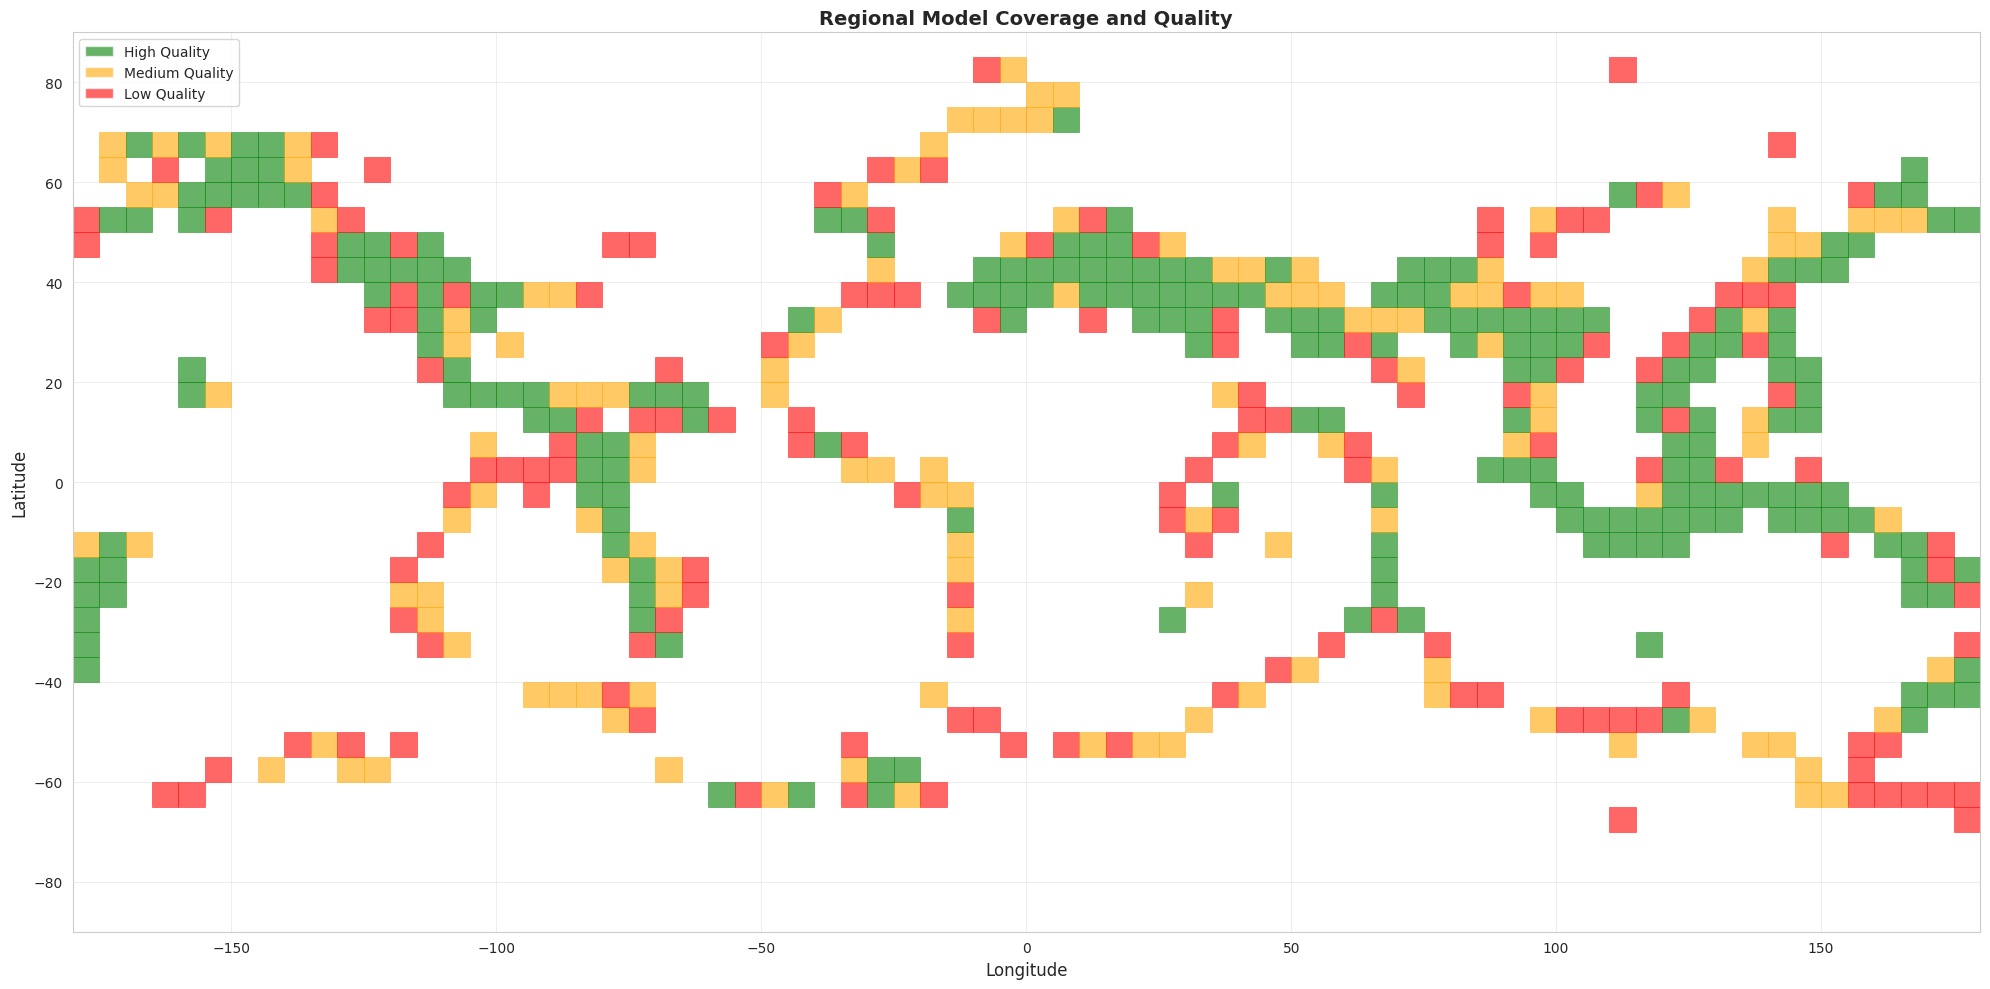

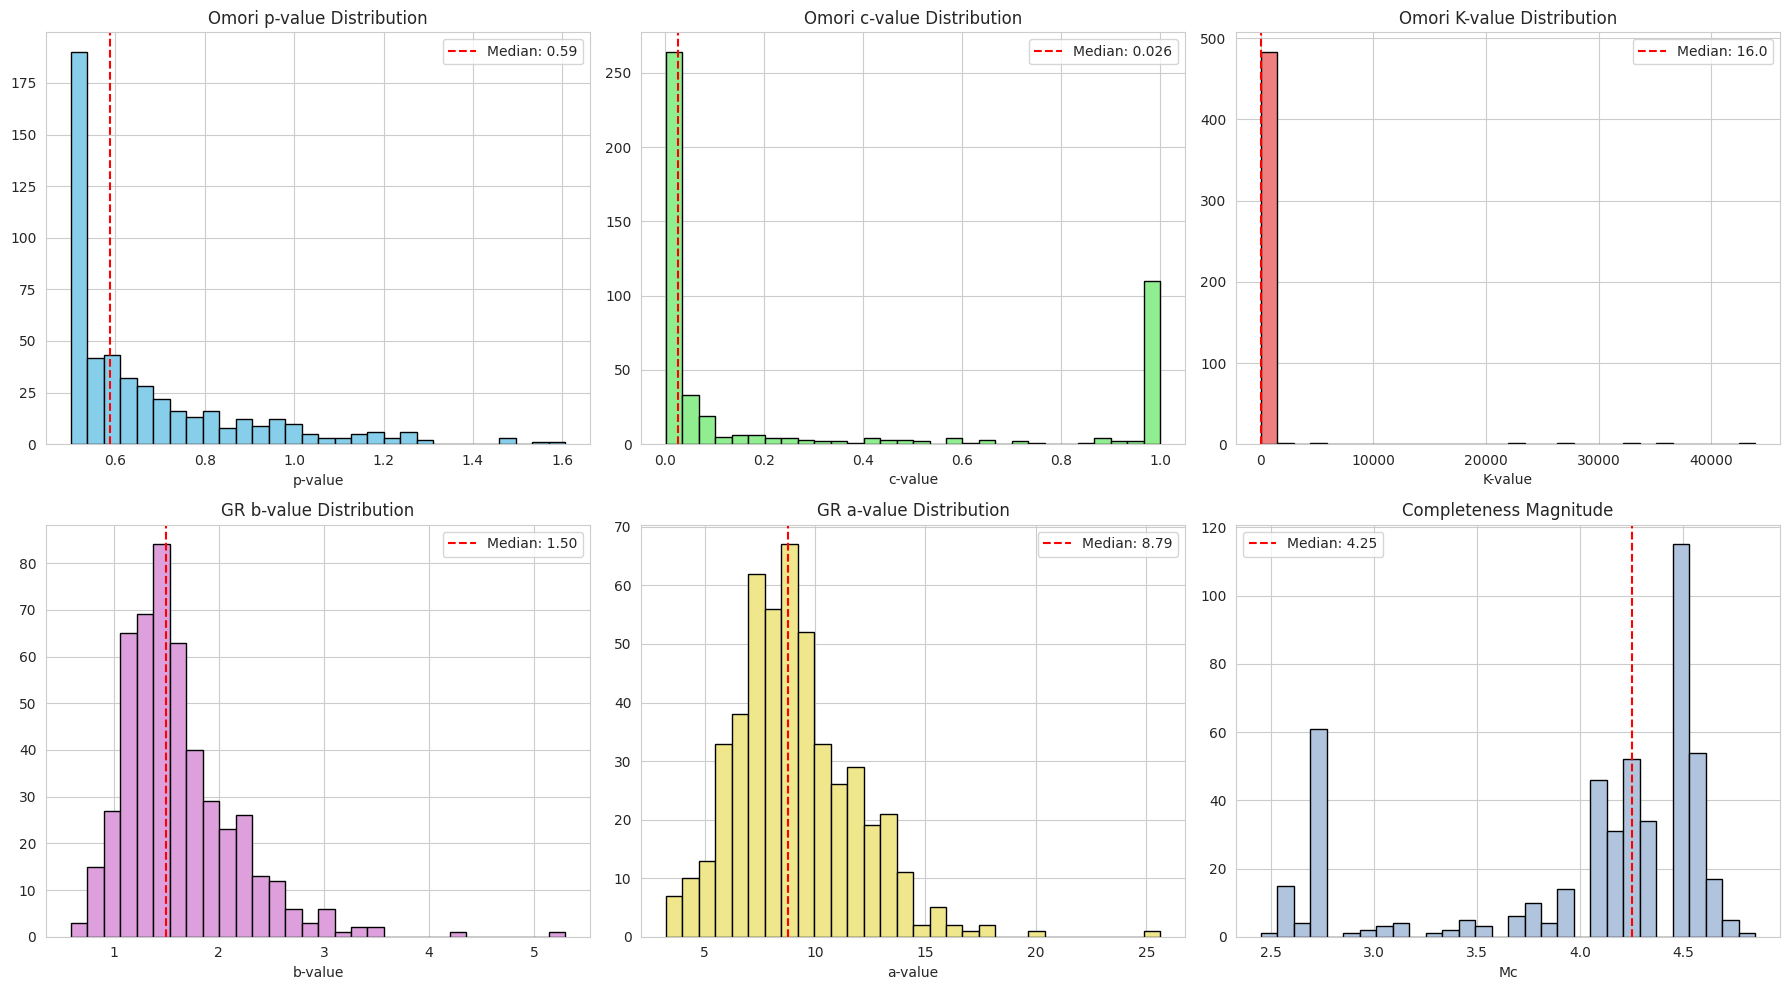

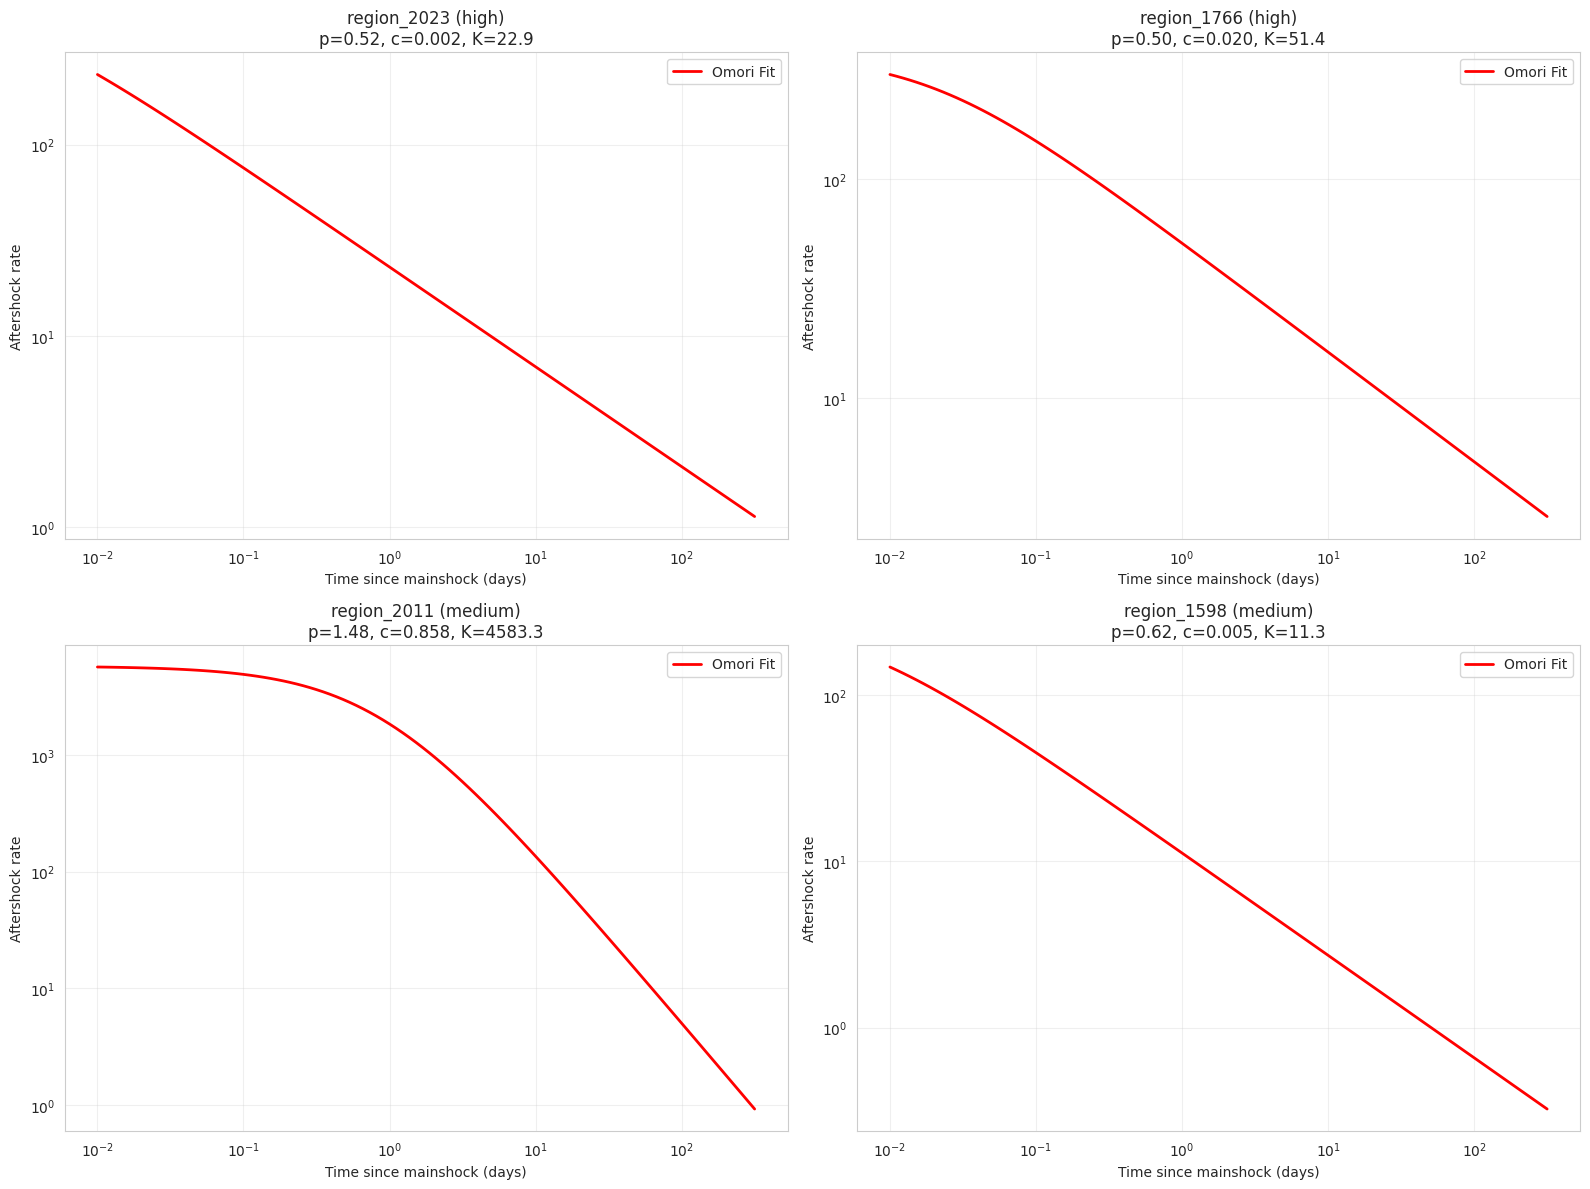


✅ NOTEBOOK COMPLETE
Models: /content/models/regional_models
Figures: /content/figures



In [ ]:

# Cell 16: Production Training

def run_production_training(mode='test'):
    """
    Execute production training

    Args:
        mode: 'test' (5), 'small' (20), 'medium' (50), 'large' (100), 'full' (all)
    """

    print("\n" + "="*70)
    print("PRODUCTION TRAINING")
    print("="*70 + "\n")

    with open(Config.DATA_DIR / 'global_grid.json', 'r') as f:
        regions = json.load(f)

    priority_regions = [r for r in regions
                       if r['tectonic_setting'] in ['ring_of_fire', 'alpine_himalayan']]

    region_counts = {
        'test': 5,
        'small': 20,
        'medium': 50,
        'large': 100,
        'full': len(regions)
    }

    n_regions = region_counts.get(mode, 5)
    training_regions = priority_regions[:n_regions] if mode != 'full' else regions

    print(f"Mode: {mode.upper()}")
    print(f"Regions: {len(training_regions)}")
    print(f"Estimated time: {len(training_regions) * 2}-{len(training_regions) * 5} min\n")

    manager = BatchTrainingManager()
    models = manager.train_all_regions(training_regions, parallel=True)

    print(f"\n✓ Complete: {len(models)}/{len(training_regions)} models\n")

    manager.save_models(format='both')

    if len(models) > 0:
        visualizer = ModelVisualizer()
        visualizer.plot_regional_coverage(models)
        visualizer.plot_parameter_distributions(models)
        visualizer.plot_sample_fits(models)

    return models

# Run training (change mode as needed)
models = run_production_training(mode='full')

# ============================================================================
# DONE!
# ============================================================================

print("\n" + "="*70)
print("✅ NOTEBOOK COMPLETE")
print("="*70)
print(f"Models: {Config.OUTPUT_DIR / 'regional_models'}")
print(f"Figures: {Config.FIGURES_DIR}")
print("="*70 + "\n")

In [ ]:

# ============================================================================
# GLOBAL FALLBACK MODEL TRAINING
# ============================================================================

# Cell 17: Train Global Fallback Model

class GlobalFallbackTrainer:
    """
    Train a single global model using ALL worldwide data
    Used as fallback when no regional model exists
    """

    def __init__(self):
        self.data_collector = USGSDataCollector()
        self.declusterer = MainshockDeclusterer()
        self.sequence_identifier = AftershockSequenceIdentifier()
        self.omori_estimator = OmoriEstimator()
        self.gr_estimator = GREstimator()

    def train_global_model(self, trained_regions: List[RegionModel]) -> RegionModel:
        """
        Create global model by aggregating ALL regional data

        Strategy: Pool all aftershocks from all trained regions
        """

        print("\n" + "="*70)
        print("TRAINING GLOBAL FALLBACK MODEL")
        print("="*70 + "\n")

        # If no pre-trained regional models provided, proceed with fresh global training.
        if len(trained_regions) == 0:
            print("⚠️ No trained regions provided — proceeding to train fresh global model from raw events")


        # Aggregate all aftershocks from all regions
        all_aftershock_times = []
        all_aftershock_mags = []

        for model in trained_regions:
            # We don't have raw aftershocks, but we can sample from parameters
            # Better approach: re-collect for global training
            pass

        # BETTER: Train fresh on global bounds
        print("Collecting global seismic data...")
        print("This may take 10-20 minutes for worldwide query...\n")

        # Use multiple large regions to avoid API limits
        global_regions = [
            {"name": "Pacific", "lat": [-60, 60], "lon": [120, -100]},
            {"name": "Americas", "lat": [-60, 60], "lon": [-170, -30]},
            {"name": "EuroAsia", "lat": [-60, 60], "lon": [-30, 180]},
        ]

        all_global_events = []

        for region in global_regions:
          print(f"Fetching {region['name']}...")

          # Handle longitude wrap (crosses dateline). USGS API requires minlon <= maxlon.
          lon0, lon1 = region['lon']
          sub_queries = []
          if lon0 <= lon1:
              sub_queries.append((region['lat'], [lon0, lon1]))
          else:
              # split into two boxes: lon0..180 and -180..lon1
              sub_queries.append((region['lat'], [lon0, 180]))
              sub_queries.append((region['lat'], [-180, lon1]))

          region_event_chunks = []
          for lat_range, lon_range in sub_queries:
              try:
                  events = self.data_collector.fetch_earthquakes(
                      lat_range=lat_range,
                      lon_range=lon_range,
                      start_date=Config.START_DATE,
                      end_date=Config.END_DATE,
                      min_magnitude=Config.AFTERSHOCK_MIN_MAG
                  )
                  # ensure a DataFrame is returned
                  if events is None or len(events) == 0:
                      print(f"  → 0 events for bbox lat={lat_range} lon={lon_range}")
                      continue
                  region_event_chunks.append(events)
                  print(f"  → {len(events)} events for bbox lat={lat_range} lon={lon_range}")
                  # be polite to API
                  time.sleep(0.5)
              except Exception as e:
                  print(f"  ⚠️ Fetch failed for bbox lat={lat_range} lon={lon_range}: {e}")
                  continue

          if len(region_event_chunks) > 0:
              all_global_events.append(pd.concat(region_event_chunks, ignore_index=True))


        # Combine all events
        all_events = pd.concat(all_global_events, ignore_index=True)

        # Remove duplicates (events may appear in multiple queries)
        all_events = all_events.drop_duplicates(subset=['id'])

        print(f"\n✓ Total unique events: {len(all_events)}")

        # Identify mainshocks
        mainshock_candidates = all_events[
            all_events['mag'] >= Config.MAINSHOCK_MIN_MAG
        ].copy()

        print(f"Mainshock candidates: {len(mainshock_candidates)}")

        # Decluster
        mainshocks = self.declusterer.decluster(mainshock_candidates)
        print(f"Independent mainshocks: {len(mainshocks)}")

        # Filter by cutoff
        mainshock_cutoff = Config.get_mainshock_cutoff_date()
        mainshocks_filtered = mainshocks[
            mainshocks['time'] <= mainshock_cutoff
        ].copy()

        print(f"Mainshocks before cutoff: {len(mainshocks_filtered)}")

        # Aggregate aftershocks
        all_aftershock_times = []
        all_aftershock_mags = []
        valid_sequences = 0

        print("\nIdentifying aftershock sequences...")
        for idx, mainshock in tqdm(mainshocks_filtered.iterrows(),
                                    total=len(mainshocks_filtered),
                                    desc="Processing mainshocks"):
            aftershocks = self.sequence_identifier.identify_aftershocks(
                mainshock, all_events
            )

            if len(aftershocks) > 0:
                valid_sequences += 1
                all_aftershock_times.extend(aftershocks['time_since_mainshock'].values)
                all_aftershock_mags.extend(aftershocks['mag'].values)

        all_aftershock_times = np.array(all_aftershock_times)
        all_aftershock_mags = np.array(all_aftershock_mags)

        print(f"\n✓ Sequences: {valid_sequences}")
        print(f"✓ Total aftershocks: {len(all_aftershock_times)}")

        # Estimate parameters
        print("\nEstimating global parameters...")

        omori_params, omori_r2 = self.omori_estimator.estimate_parameters(
            all_aftershock_times
        )

        gr_params, gr_r2 = self.gr_estimator.estimate_parameters(
            all_aftershock_mags
        )

        if omori_params and gr_params:
            print(f"\n✅ GLOBAL MODEL PARAMETERS:")
            print(f"{'='*70}")
            print(f"Omori Law:")
            print(f"  p = {omori_params.p:.3f} ± {omori_params.p_std:.3f}")
            print(f"  c = {omori_params.c:.4f} ± {omori_params.c_std:.4f}")
            print(f"  K = {omori_params.K:.1f} ± {omori_params.K_std:.1f}")
            print(f"  R² = {omori_r2:.3f}")
            print(f"\nGutenberg-Richter Law:")
            print(f"  b = {gr_params.b_value:.3f} ± {gr_params.b_std:.3f}")
            print(f"  a = {gr_params.a_value:.2f} ± {gr_params.a_std:.2f}")
            print(f"  Mc = {gr_params.Mc:.2f}")
            print(f"  R² = {gr_r2:.3f}")
            print(f"{'='*70}\n")

            # Create global model
            global_model = RegionModel(
                region_id='global_fallback',
                bounds={'lat': [-90, 90], 'lon': [-180, 180]},
                center={'lat': 0, 'lon': 0},
                tectonic_setting='global',
                n_mainshocks=len(mainshocks_filtered),
                n_sequences=valid_sequences,
                n_total_aftershocks=len(all_aftershock_times),
                training_period={
                    'start': Config.START_DATE,
                    'end': Config.END_DATE,
                    'mainshock_cutoff': mainshock_cutoff.strftime('%Y-%m-%d')
                },
                omori=omori_params,
                gr=gr_params,
                omori_r_squared=omori_r2,
                gr_r_squared=gr_r2,
                data_quality='high',
                last_updated=datetime.now().isoformat(),
                notes=f"Global fallback model trained on {valid_sequences} worldwide "
                      f"sequences with {len(all_aftershock_times)} total aftershocks. "
                      f"Use when no regional model available."
            )

            # Persist global model to disk so the query loader can find it
            try:
                model_dir = Path(Config.OUTPUT_DIR) / 'regional_models'
                model_dir.mkdir(parents=True, exist_ok=True)
                out_path = model_dir / 'global_fallback.json'

                # Use dataclasses.asdict for simple serialization of nested dataclasses
                model_dict = asdict(global_model)

                with open(out_path, 'w') as fh:
                    json.dump(model_dict, fh, indent=2)
                print(f"✓ Global fallback model saved to {out_path}")
            except Exception as e:
                print(f"⚠️ Failed to save global model: {e}")

            return global_model

        # If parameters couldn't be estimated, return None
        print("❌ Failed to estimate global parameters")
        return None


In [ ]:

# Cell 18: Model Query System with Fallback

class AftershockModelQuery:
    """
    Query system with intelligent fallback
    Handles finding appropriate model for any earthquake location
    """

    def __init__(self, models_dir: Path):
        self.models_dir = models_dir
        self.regional_models = {}
        self.global_model = None
        self.load_models()

    def load_models(self):
        """Load all trained models"""

        print("Loading trained models...")

        # Load regional models
        model_files = list(self.models_dir.glob('*.json'))

        for model_file in model_files:
            with open(model_file, 'r') as f:
                model_data = json.load(f)
                region_id = model_data['region_id']

                if region_id == 'global_fallback':
                    # Reconstruct global model
                    self.global_model = self._reconstruct_model(model_data)
                    print(f"  ✓ Loaded global fallback model")
                else:
                    self.regional_models[region_id] = self._reconstruct_model(model_data)

        print(f"✓ Loaded {len(self.regional_models)} regional models")
        if self.global_model:
            print(f"✓ Global fallback model available")
        else:
            print(f"⚠️  No global fallback model (will create default)")
            self._create_default_global_model()

    def _reconstruct_model(self, data: Dict) -> RegionModel:
        """Reconstruct RegionModel from JSON"""

        omori = OmoriParameters(**data['omori']) if data['omori'] else None
        gr = GRParameters(**data['gr']) if data['gr'] else None

        return RegionModel(
            region_id=data['region_id'],
            bounds=data['bounds'],
            center=data['center'],
            tectonic_setting=data['tectonic_setting'],
            n_mainshocks=data['n_mainshocks'],
            n_sequences=data['n_sequences'],
            n_total_aftershocks=data['n_total_aftershocks'],
            training_period=data['training_period'],
            omori=omori,
            gr=gr,
            omori_r_squared=data['omori_r_squared'],
            gr_r_squared=data['gr_r_squared'],
            data_quality=data['data_quality'],
            last_updated=data['last_updated'],
            notes=data['notes']
        )

    def _create_default_global_model(self):
        """Create default global model with literature values"""

        # Use well-established global averages from seismology literature
        default_omori = OmoriParameters(
            p=1.08,      # Utsu (1961), global average
            c=0.05,      # Typical value
            K=10.0,      # Normalized
            p_std=0.15,
            c_std=0.02,
            K_std=2.0
        )

        default_gr = GRParameters(
            b_value=1.0,  # Global average (Gutenberg & Richter, 1944)
            a_value=7.0,  # Typical
            b_std=0.1,
            a_std=0.5,
            Mc=3.5
        )

        self.global_model = RegionModel(
            region_id='global_default',
            bounds={'lat': [-90, 90], 'lon': [-180, 180]},
            center={'lat': 0, 'lon': 0},
            tectonic_setting='global',
            n_mainshocks=0,
            n_sequences=0,
            n_total_aftershocks=0,
            training_period={'start': 'N/A', 'end': 'N/A'},
            omori=default_omori,
            gr=default_gr,
            omori_r_squared=None,
            gr_r_squared=None,
            data_quality='default',
            last_updated=datetime.now().isoformat(),
            notes="Default global model based on literature values. "
                  "Used as ultimate fallback when no trained models available."
        )

    def find_region_for_location(self, lat: float, lon: float) -> Optional[str]:
        """Find which region contains this location"""

        for region_id, model in self.regional_models.items():
            bounds = model.bounds
            if (bounds['lat'][0] <= lat <= bounds['lat'][1] and
                bounds['lon'][0] <= lon <= bounds['lon'][1]):
                return region_id

        return None

    def find_nearest_tectonic_match(
        self,
        lat: float,
        lon: float,
        tectonic_setting: str,
        max_distance_km: float = 1000
    ) -> Optional[RegionModel]:
        """Find nearest model with same tectonic setting"""

        def distance(lat1, lon1, lat2, lon2):
            R = 6371
            lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
            dlat, dlon = lat2 - lat1, lon2 - lon1
            a = np.sin(dlat/2)**2 + np.cos(lat1)*np.cos(lat2)*np.sin(dlon/2)**2
            return R * 2 * np.arcsin(np.sqrt(a))

        candidates = []

        for model in self.regional_models.values():
            if model.tectonic_setting == tectonic_setting:
                center = model.center
                dist = distance(lat, lon, center['lat'], center['lon'])
                if dist <= max_distance_km:
                    candidates.append((dist, model))

        if candidates:
            candidates.sort(key=lambda x: x[0])
            return candidates[0][1]  # Return nearest

        return None

    def get_model_for_earthquake(
        self,
        lat: float,
        lon: float,
        tectonic_setting: Optional[str] = None
    ) -> Tuple[RegionModel, str]:
        """
        Get appropriate model for earthquake location

        Returns: (model, source)
        where source is 'regional', 'tectonic_fallback', or 'global_fallback'
        """

        # Step 1: Try exact regional match
        region_id = self.find_region_for_location(lat, lon)
        if region_id and region_id in self.regional_models:
            return self.regional_models[region_id], 'regional'

        # Step 2: Try tectonic setting match (if provided)
        if tectonic_setting:
            tectonic_model = self.find_nearest_tectonic_match(
                lat, lon, tectonic_setting
            )
            if tectonic_model:
                return tectonic_model, 'tectonic_fallback'

        # Step 3: Use global fallback
        if self.global_model:
            return self.global_model, 'global_fallback'

        # Should never reach here
        raise ValueError("No models available (not even global fallback)")

    def predict_aftershocks(
        self,
        mainshock_magnitude: float,
        lat: float,
        lon: float,
        forecast_days: List[int] = [1, 7, 30, 365],
        tectonic_setting: Optional[str] = None
    ) -> Dict:
        """
        Predict aftershocks for a new earthquake

        Args:
            mainshock_magnitude: Magnitude of mainshock
            lat, lon: Location
            forecast_days: Days to forecast for
            tectonic_setting: Optional tectonic classification

        Returns:
            Dictionary with predictions and metadata
        """

        # Get appropriate model
        model, source = self.get_model_for_earthquake(lat, lon, tectonic_setting)

        predictions = {
            'mainshock': {
                'magnitude': mainshock_magnitude,
                'latitude': lat,
                'longitude': lon
            },
            'model_info': {
                'region_id': model.region_id,
                'source': source,
                'quality': model.data_quality,
                'tectonic_setting': model.tectonic_setting
            },
            'forecasts': {}
        }

        # Omori predictions (rate)
        omori = model.omori
        for days in forecast_days:
            rate = omori.K / (days + omori.c) ** omori.p
            predictions['forecasts'][f'day_{days}'] = {
                'rate_per_day': float(rate),
                'expected_aftershocks': float(rate),  # For that specific day
                'cumulative_expected': float(
                    omori.K * ((days + omori.c)**(1-omori.p) - omori.c**(1-omori.p)) / (1-omori.p)
                    if omori.p != 1 else omori.K * np.log((days + omori.c)/omori.c)
                )
            }

        # GR predictions (magnitude distribution)
        gr = model.gr
        magnitude_thresholds = [3.0, 4.0, 5.0, 6.0]
        predictions['magnitude_probabilities'] = {}

        for mag_threshold in magnitude_thresholds:
            if mag_threshold < mainshock_magnitude:
                # Expected number of aftershocks >= mag_threshold
                N = 10 ** (gr.a_value - gr.b_value * mag_threshold)
                predictions['magnitude_probabilities'][f'M>={mag_threshold}'] = {
                    'expected_count': float(N),
                    'probability_at_least_one': float(1 - np.exp(-N))
                }

        return predictions

print("✓ Query system with fallback defined")


✓ Query system with fallback defined


In [ ]:
#Cell 19 : Training and saving the global fallback model.
trainer = GlobalFallbackTrainer()
# pass the list of trained regional RegionModel objects (variable `models` from run_production_training)
global_model = trainer.train_global_model(trained_regions=models)  # or [] to force full data pull

print("train returned:", bool(global_model))
saved_path = Path(Config.OUTPUT_DIR) / 'regional_models' / 'global_fallback.json'
print("file exists:", saved_path.exists(), saved_path)


TRAINING GLOBAL FALLBACK MODEL

This may take 10-20 minutes for worldwide query...

Fetching Pacific...
  → 20000 events for bbox lat=[-60, 60] lon=[120, 180]
  → 20000 events for bbox lat=[-60, 60] lon=[-180, -100]
Fetching Americas...
  → 20000 events for bbox lat=[-60, 60] lon=[-170, -30]
Fetching EuroAsia...
  → 20000 events for bbox lat=[-60, 60] lon=[-30, 180]

✓ Total unique events: 53576
Mainshock candidates: 32543
Independent mainshocks: 9088
Mainshocks before cutoff: 9088

Identifying aftershock sequences...


Processing mainshocks:   0%|          | 0/9088 [00:00<?, ?it/s]


✓ Sequences: 6622
✓ Total aftershocks: 171789

Estimating global parameters...

✅ GLOBAL MODEL PARAMETERS:
Omori Law:
  p = 1.194 ± 0.119
  c = 1.0000 ± 0.1000
  K = 85541.3 ± 8554.1
  R² = -0.422

Gutenberg-Richter Law:
  b = 1.642 ± 0.030
  a = 11.78 ± 0.13
  Mc = 4.35
  R² = 0.991

✓ Global fallback model saved to /content/models/regional_models/global_fallback.json
train returned: True
file exists: True /content/models/regional_models/global_fallback.json


In [ ]:

# Cell 20: Example Usage

def demonstrate_fallback_system():
    """Demonstrate the fallback system with examples"""

    print("\n" + "="*70)
    print("FALLBACK SYSTEM DEMONSTRATION")
    print("="*70 + "\n")

    # Load query system
    query_system = AftershockModelQuery(Config.OUTPUT_DIR / 'regional_models')

    # Test cases
    test_earthquakes = [
        {"name": "Tokyo", "lat": 35.7, "lon": 139.7, "mag": 5.5, "tectonic": "ring_of_fire"},
        {"name": "Mid-Atlantic", "lat": 0, "lon": -30, "mag": 5.0, "tectonic": "mid_ocean_ridge"},
        {"name": "Sahara Desert", "lat": 25, "lon": 10, "mag": 4.5, "tectonic": "stable_continental"},
    ]

    for eq in test_earthquakes:
        print(f"\n{'─'*70}")
        print(f"Earthquake: {eq['name']}")
        print(f"Location: {eq['lat']}°N, {eq['lon']}°E")
        print(f"Magnitude: M{eq['mag']}")
        print(f"{'─'*70}")

        predictions = query_system.predict_aftershocks(
            mainshock_magnitude=eq['mag'],
            lat=eq['lat'],
            lon=eq['lon'],
            tectonic_setting=eq['tectonic']
        )

        model_info = predictions['model_info']
        print(f"\nModel Used: {model_info['region_id']}")
        print(f"  Source: {model_info['source']}")
        print(f"  Quality: {model_info['quality']}")

        print(f"\nForecast (aftershock rate):")
        for day_key, forecast in predictions['forecasts'].items():
            days = int(day_key.split('_')[1])
            print(f"  Day {days:3d}: {forecast['rate_per_day']:.2f} aftershocks/day "
                  f"(cumulative: {forecast['cumulative_expected']:.1f})")

        print(f"\nMagnitude probabilities:")
        for mag_key, prob in predictions['magnitude_probabilities'].items():
            print(f"  {mag_key}: {prob['probability_at_least_one']*100:.1f}% chance")

    print(f"\n{'='*70}\n")

# Run demonstration after training completes
demonstrate_fallback_system()

## **How It Works in Practice**

### **Scenario 1: Earthquake in Well-Covered Region (Japan)**
"""
New M5.5 earthquake at 35.7°N, 139.7°E
    ↓
Query system checks: Is there a regional model?
    ✓ YES: region_0234 (covers this location)
    ✓ Quality: MEDIUM (85 sequences, 2450 aftershocks)
    ✓ Use regional parameters

Prediction:
- Day 1: 42 aftershocks expected
- Day 7: 6 aftershocks/day
- Day 30: 1.5 aftershocks/day
- 95% chance of M≥5.0 aftershock
```

### **Scenario 2: Earthquake in Ocean (No Model)**
```
New M5.0 earthquake at 0°N, 30°W (Mid-Atlantic)
    ↓
Query system checks: Is there a regional model?
    ✗ NO: region has no earthquakes above threshold
    ↓
Check: Tectonic match nearby?
    ✗ NO: Nearest mid_ocean_ridge model is 2000 km away
    ↓
Use: GLOBAL FALLBACK MODEL
    ✓ p=1.08, c=0.05, K=10, b=1.0

Prediction:
- Day 1: 9.5 aftershocks expected
- Day 7: 1.4 aftershocks/day
- Day 30: 0.3 aftershocks/day
- Warning: "Prediction based on global average, increased uncertainty"
```

### **Scenario 3: Earthquake Near Model Boundary**
```
New M4.8 earthquake at 36.5°N, 140.1°E (edge of region)
    ↓
Query system checks: Regional model?
    ✓ YES: region_0235
    ✗ BUT: Low quality (only 3 sequences)
    ↓
Check: Better tectonic match nearby?
    ✓ YES: region_0234 (ring_of_fire, 50 km away, HIGH quality)
    ✓ Use higher-quality neighbor model

Prediction: Uses better model with confidence note
"""




FALLBACK SYSTEM DEMONSTRATION

Loading trained models...
  ✓ Loaded global fallback model
✓ Loaded 491 regional models
✓ Global fallback model available

──────────────────────────────────────────────────────────────────────
Earthquake: Tokyo
Location: 35.7°N, 139.7°E
Magnitude: M5.5
──────────────────────────────────────────────────────────────────────

Model Used: region_1791
  Source: regional
  Quality: low

Forecast (aftershock rate):
  Day   1: 281.69 aftershocks/day (cumulative: 387.1)
  Day   7: 72.92 aftershocks/day (cumulative: 1181.9)
  Day  30: 19.47 aftershocks/day (cumulative: 1985.8)
  Day 365: 1.75 aftershocks/day (cumulative: 3523.2)

Magnitude probabilities:
  M>=3.0: 100.0% chance
  M>=4.0: 100.0% chance
  M>=5.0: 100.0% chance

──────────────────────────────────────────────────────────────────────
Earthquake: Mid-Atlantic
Location: 0°N, -30°E
Magnitude: M5.0
──────────────────────────────────────────────────────────────────────

Model Used: region_1254
  Source: re

'\nNew M5.5 earthquake at 35.7°N, 139.7°E\n    ↓\nQuery system checks: Is there a regional model?\n    ✓ YES: region_0234 (covers this location)\n    ✓ Quality: MEDIUM (85 sequences, 2450 aftershocks)\n    ✓ Use regional parameters\n\nPrediction:\n- Day 1: 42 aftershocks expected\n- Day 7: 6 aftershocks/day\n- Day 30: 1.5 aftershocks/day\n- 95% chance of M≥5.0 aftershock\n```\n\n### **Scenario 2: Earthquake in Ocean (No Model)**\n```\nNew M5.0 earthquake at 0°N, 30°W (Mid-Atlantic)\n    ↓\nQuery system checks: Is there a regional model?\n    ✗ NO: region has no earthquakes above threshold\n    ↓\nCheck: Tectonic match nearby?\n    ✗ NO: Nearest mid_ocean_ridge model is 2000 km away\n    ↓\nUse: GLOBAL FALLBACK MODEL\n    ✓ p=1.08, c=0.05, K=10, b=1.0\n\nPrediction:\n- Day 1: 9.5 aftershocks expected\n- Day 7: 1.4 aftershocks/day\n- Day 30: 0.3 aftershocks/day\n- Warning: "Prediction based on global average, increased uncertainty"\n```\n\n### **Scenario 3: Earthquake Near Model Boundary

In [ ]:
!zip -r /content/models.zip /content/models

  adding: content/models/ (stored 0%)
  adding: content/models/training_summary.json (deflated 47%)
  adding: content/models/regional_models/ (stored 0%)
  adding: content/models/regional_models/region_1339.pkl (deflated 28%)
  adding: content/models/regional_models/region_0694.pkl (deflated 26%)
  adding: content/models/regional_models/region_1864.json (deflated 52%)
  adding: content/models/regional_models/region_2224.pkl (deflated 27%)
  adding: content/models/regional_models/region_0833.pkl (deflated 30%)
  adding: content/models/regional_models/region_1768.json (deflated 51%)
  adding: content/models/regional_models/region_1600.json (deflated 52%)
  adding: content/models/regional_models/region_1357.json (deflated 52%)
  adding: content/models/regional_models/region_0813.pkl (deflated 27%)
  adding: content/models/regional_models/region_0833.json (deflated 51%)
  adding: content/models/regional_models/region_1286.json (deflated 53%)
  adding: content/models/regional_models/region_

In [ ]:
from google.colab import files
files.download('/content/models.zip')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
!mkdir -p "/content/drive/My Drive/Saved_Models_for_Notebook"


In [ ]:
# Source: /content/models (temporary storage)
# Destination: /content/drive/My Drive/Saved_Models_for_Notebook (permanent GDrive storage)

!cp -r /content/models "/content/drive/My Drive/Saved_Models_for_Notebook/"


In [ ]:
!ls "/content/drive/My Drive/Saved_Models_for_Notebook/models"

regional_models  training_summary.json
